In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from IPython.display import HTML


Codigo normal

In [12]:
def build_up_b(rho, dt, u, v, dx, dy):
    """
    Construye el término del lado derecho de la ecuación de Poisson para la presión a partir de los campos de velocidad u y v.

    Parameters:
     - rho : Densidad del fluido.
     - dt : Paso temporal.
     - u : Componente horizontal de la velocidad.
     - v : Componente vertical de la velocidad.
     - dx : Tamaño de celda en x.
     - dy : Tamaño de celda en y.
    Returns:
     - b : Matriz del término fuente para la ecuación de Poisson.
    """
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = rho * ((1/dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx) + 
                                     (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy)) - 
                         ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx))**2 - 
                         2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy) * 
                              (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2*dx)) - 
                         ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy))**2)

    return b

def pressure_poisson(p, b, dx, dy, nit=50):
    """
    Resuelve la ecuación de Poisson para el campo de presión `p` utilizando un método iterativo 

    Parameters:
    p : Campo inicial de presión.
    b : Lado derecho de la Ecuación.
    dx : Tamaño de celda en x.
    dy : Tamaño de celda en y.
    nit : Número de iteraciones para el método iterativo (default 50).

    Returns:
    p : ndarray
        Campo de presión actualizado.
    """
    pn = np.empty_like(p)
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
             dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) -
             b[1:-1, 1:-1] * dx**2 * dy**2)
            / (2 * (dx**2 + dy**2))
        )

        p[:, -1] = p[:, -2]  # salida
        p[:, 0] = p[:, 1]    # entrada
        p[0, :] = p[1, :]    # pared inferior
        p[-1, :] = p[-2, :]  # pared superior
    return p

def simulation(a, b, d, u0, nu, nx=41, ny=41, nt=100):
    rho = 1
    dx = b / (nx - 1)
    dy = a / (ny - 1)
    dt = 0.01
    F = 1

    r = a / 25
    xc = d
    yc = a / 2

    x = np.linspace(0, b, nx)
    y = np.linspace(0, a, ny)
    X, Y = np.meshgrid(x, y)

    obstacle_mask = (X - xc)**2 + (Y - yc)**2 <= r**2

    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    stepcount = 0
    for _ in range(nt):
        un = u.copy()
        vn = v.copy()

        b_mat = build_up_b(rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, b_mat, dx, dy)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * 
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                        F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
            un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
            vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
            dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
            nu * (dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        u[:, 0] = u0
        u[:, -1] = u[:, -2]
        v[:, 0] = 0
        v[:, -1] = 0
        u[0, :] = u0
        u[-1, :] = u0
        v[0, :] = 0
        v[-1, :] = 0

        udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)
        if np.isnan(udiff) or udiff > 1:
            return None  # Simulación fallida
        stepcount += 1

    return True  # Simulación estable




mejora

In [8]:
def build_up_b_2(rho, dt, u, v, dx, dy):
    """
    Construye el término del lado derecho de la ecuación de Poisson para la presión a partir de los campos de velocidad u y v.
    Parameters:
     - rho : Densidad del fluido.
     - dt : Paso temporal.
     - u : Componente horizontal de la velocidad.
     - v : Componente vertical de la velocidad.
     - dx : Tamaño de celda en x (puede ser escalar o matriz).
     - dy : Tamaño de celda en y (puede ser escalar o matriz).
    Returns:
     - b : Matriz del término fuente para la ecuación de Poisson.
    """
    b = np.zeros_like(u)
    
    # Si dx y dy son matrices, extraemos la parte interior
    if np.isscalar(dx):
        dx_inner = dx
    else:
        dx_inner = dx[1:-1, 1:-1]
    
    if np.isscalar(dy):
        dy_inner = dy
    else:
        dy_inner = dy[1:-1, 1:-1]
    
    b[1:-1, 1:-1] = rho * ((1/dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner) +
                                     (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner)) -
                          ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy_inner) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2*dx_inner)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner))**2)
    return b

def pressure_poisson_2(p, b, dx, dy, nit=50):
    """
    Resuelve la ecuación de Poisson para la presión usando el método iterativo de Jacobi.
    
    Parameters:
    - p : Campo de presión inicial.
    - b : Término fuente de la ecuación de Poisson.
    - dx : Tamaño de celda en x (puede ser escalar o matriz).
    - dy : Tamaño de celda en y (puede ser escalar o matriz).
    - nit : Número de iteraciones.
    
    Returns:
    - p : Campo de presión actualizado.
    """
    pn = np.empty_like(p)
    
    # Si dx y dy son matrices, extraemos la parte interior
    if np.isscalar(dx):
        dx_inner = dx
    else:
        dx_inner = dx[1:-1, 1:-1]
    
    if np.isscalar(dy):
        dy_inner = dy
    else:
        dy_inner = dy[1:-1, 1:-1]
    
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (dy_inner**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
             dx_inner**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) -
             b[1:-1, 1:-1] * dx_inner**2 * dy_inner**2)
            / (2 * (dx_inner**2 + dy_inner**2))
        )
        
        # Condiciones de frontera para la presión
        p[:, -1] = p[:, -2]  # salida
        p[:, 0] = p[:, 1]    # entrada
        p[0, :] = p[1, :]    # pared inferior
        p[-1, :] = p[-2, :]  # pared superior
        
    return p

def simulation_2(a, b, d, u0, nu, nx=41, ny=41, nt=100, dt=0.001, better=False):
    """
    Ejecuta una simulación bidimensional del flujo de un fluido incompresible 
    alrededor de un obstáculo circular en un canal rectangular.
    """
    rho = 1   # densidad
    F = 0     # fuerza externa (agregar si es necesario)
    
    x = np.linspace(0, b, nx)
    y = np.linspace(0, a, ny)

    X, Y = np.meshgrid(x, y)

    # Crear matrices dx_refined y dy_refined con las mismas dimensiones que u y v
    dx_base = b / (nx - 1)
    dy_base = a / (ny - 1)
    
    dx_refined = np.full((ny, nx), dx_base)
    dy_refined = np.full((ny, nx), dy_base)

    # Dimensiones del obstáculo
    r = a / 25
    xc = d
    yc = a / 2

    # Máscara para el obstáculo y el contorno
    obstacle_mask = (X - xc)**2 + (Y - yc)**2 <= r**2
    obstacle_edge = binary_dilation(obstacle_mask) & (~obstacle_mask)

    # Máscara de refinamiento
    refinement_radius = r * 3  # Tres veces el radio del obstáculo
    refinement_mask = (X - xc)**2 + (Y - yc)**2 <= (r + refinement_radius)**2

    # Inicialización de vectores
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))
    
    # Condición inicial
    u[:, :] = u0

    forces = []
    states = []

    stepcount = 0
    for step in range(nt):
        un = u.copy()
        vn = v.copy()

        # Refinar el tamaño de las celdas en la zona de refinamiento cerca del obstáculo
        if better:
            # SOLUCIÓN: Crear matrices con los valores refinados
            dx_refined = np.where(refinement_mask, dx_base / 2, dx_base)
            dy_refined = np.where(refinement_mask, dy_base / 2, dy_base)
        else:
            # Mantener tamaño uniforme
            dx_refined = np.full((ny, nx), dx_base)
            dy_refined = np.full((ny, nx), dy_base)

        # Cálculo del término b para la ecuación de Poisson (con tamaños de celda refinados)
        b_term = build_up_b_2(rho, dt, u, v, dx_refined, dy_refined)

        # Resolver la ecuación de Poisson
        p = pressure_poisson_2(p, b_term, dx_refined, dy_refined)

        # Calcular la fuerza sobre el obstáculo
        if np.any(obstacle_edge):
            force_t = np.sum(p[obstacle_edge] * dx_refined[obstacle_edge] * dy_refined[obstacle_edge])
            forces.append(force_t)
        else:
            forces.append(0)

        # Actualizar las velocidades con la fórmula de Navier-Stokes (ajustado para malla refinada)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] *
                         (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx_refined[1:-1, 1:-1]) *
                         (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 *
                         (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy_refined[1:-1, 1:-1]**2 *
                         (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) +
                         F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy_refined[1:-1, 1:-1] * 
                         (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy_refined[1:-1, 1:-1]) * 
                         (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx_refined[1:-1, 1:-1]**2 * 
                         (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                               dt / dy_refined[1:-1, 1:-1]**2 * 
                         (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Incorporación del Obstáculo
        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        # Condiciones de frontera
        u[:, 0] = u0       # entrada
        u[:, -1] = u[:, -2] # salida
        v[:, 0] = 0
        v[:, -1] = 0

        u[0, :] = u0       # pared inferior
        u[-1, :] = u0      # pared superior
        v[0, :] = 0
        v[-1, :] = 0

        # states.append((u.copy(), v.copy(), p.copy()))  # Necesario para la animación
        udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)
        if np.isnan(udiff) or udiff > 1:
            return None  # Simulación fallida
        stepcount += 1

    return True
    # return u, v, p, X, Y, nt, forces, states, obstacle_mask, xc, yc, r


pruebas

C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3254536017.py:117: RuntimeWarning: invalid value encountered in scalar divide
  udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)


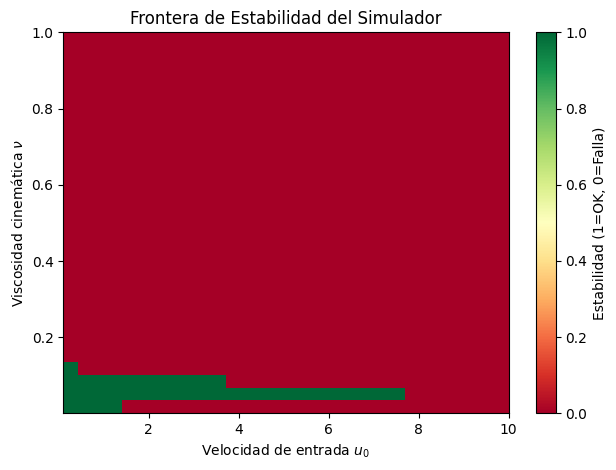

CPU times: total: 11.6 s
Wall time: 19.5 s


In [14]:
%%time

# normal

# Grid de valores para u0 y nu
u0_values = np.linspace(0.1, 10, 30)
nu_values = np.linspace(0.001, 1, 30)
stability_map = np.zeros((len(u0_values), len(nu_values)))

# Ejecutar simulaciones
for i, u0 in enumerate(u0_values):
    for j, nu in enumerate(nu_values):
        result = simulation(a=2, b=4, d=1, u0=u0, nu=nu, nt=100)
        stability_map[i, j] = 1 if result is not None else 0

# Graficar el mapa de estabilidad
plt.imshow(stability_map.T, extent=[u0_values[0], u0_values[-1], nu_values[0], nu_values[-1]],
           origin='lower', aspect='auto', cmap='RdYlGn')
plt.xlabel('Velocidad de entrada $u_0$')
plt.ylabel('Viscosidad cinemática $\\nu$')
plt.title('Frontera de Estabilidad del Simulador')
plt.colorbar(label='Estabilidad (1=OK, 0=Falla)')
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:193: RuntimeWarning: invalid value encountered in scalar divide
  udiff = np.linalg.norm(u - un) / (np.linalg.norm(u) + 1e-6)
C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:29: RuntimeWarning: overflow encountered in square
  ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx_inner))**2 -
C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:32: RuntimeWarning: overflow encountered in square
  ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy_inner))**2)
C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:158: RuntimeWarning: invalid value encountered in subtract
  (p[1:-1, 2:] - p[1:-1, 0:-2]) +
C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:171: RuntimeWarning: invalid value encountered in subtract
  (p[2:, 1:-1] - p[0:-2, 1:-1]) +
C:\Users\vicen\AppData\Local\Temp\ipykernel_20576\3388459327.py:30: RuntimeWarning: overflow encountered in divide
  2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy

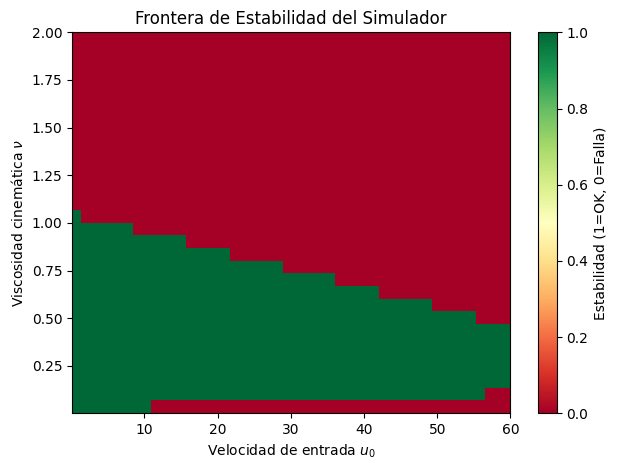

CPU times: total: 2min 11s
Wall time: 3min 48s


In [19]:
%%time

# mejor

# Grid de valores para u0 y nu
u0_values = np.linspace(0.1, 60, 50)
nu_values = np.linspace(0.001, 2, 30)
stability_map = np.zeros((len(u0_values), len(nu_values)))

# Ejecutar simulaciones
for i, u0 in enumerate(u0_values):
    for j, nu in enumerate(nu_values):
        result = simulation_2(a=2, b=4, d=1, u0=u0, nu=nu, nt=100)
        stability_map[i, j] = 1 if result is not None else 0

# Graficar el mapa de estabilidad
plt.imshow(stability_map.T, extent=[u0_values[0], u0_values[-1], nu_values[0], nu_values[-1]],
           origin='lower', aspect='auto', cmap='RdYlGn')
plt.xlabel('Velocidad de entrada $u_0$')
plt.ylabel('Viscosidad cinemática $\\nu$')
plt.title('Frontera de Estabilidad del Simulador')
plt.colorbar(label='Estabilidad (1=OK, 0=Falla)')
plt.grid(False)
plt.tight_layout()
plt.show()